In [1]:
!pip install transformers[sentencepiece] datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### The Extreme Summarization (XSum) Dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("xsum")
dataset

Using custom data configuration default


Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Dataset xsum downloaded and prepared to /root/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

EDA

In [3]:
import pandas as pd

train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

train_data.set_format(type="pandas")
df = train_data[:]
df.head()

,document,summary,id
0,"The full cost of damage in Newton Stewart, one...",Clean-up operations are continuing across the ...,35232142
1,A fire alarm went off at the Holiday Inn in Ho...,Two tourist buses have been destroyed by fire ...,40143035
2,Ferrari appeared in a position to challenge un...,Lewis Hamilton stormed to pole position at the...,35951548
3,"John Edward Bates, formerly of Spalding, Linco...",A former Lincolnshire Police officer carried o...,36266422
4,Patients and staff were evacuated from Cerahpa...,An armed man who locked himself into a room at...,38826984


In [4]:
import numpy as np
import matplotlib.pyplot as plt

average length of the text:  2202.116052831483 and summary:  125.46304981744223
SD of length of the text:  1795.6165104035636 and summary:  30.241383662373767
max length of the text:  174045 and summary:  399


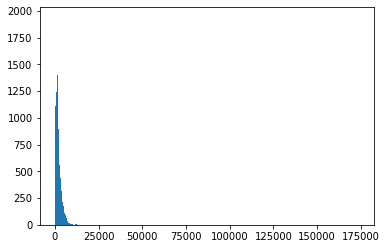

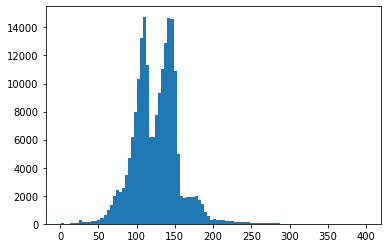

In [5]:
def get_statistics():
  length = len(df['document'])
  doc_length = []
  smy_length = []
  for i in range(length):
    doc_length.append(len(df['document'][i]))
    smy_length.append(len(df['summary'][i]))
  doc_length_avg = sum(doc_length) / length
  smy_length_avg = sum(smy_length) / length
  print("average length of the text: ", doc_length_avg, "and summary: ", smy_length_avg)
  print("SD of length of the text: ", np.std(doc_length), "and summary: ", np.std(smy_length))
  print("max length of the text: ", np.max(doc_length), "and summary: ", np.max(smy_length))

  plt.hist(np.array(doc_length), 10000)
  plt.show()
  plt.hist(np.array(smy_length), 100)
  plt.show()


get_statistics()

In [6]:
# reset format
train_data.reset_format()

### Text Summarization Pipelines

In [7]:
from transformers import pipeline

sample_text = dataset["train"][0]["document"][:2000]   # the first training instance (truncating to 2000 words)
summaries = {}

In [10]:
# A convention in summarization is to separate the summary sentences each by a newline
# could try to add a newline "\n" after each full stop, but there may be some punctuation that occurs in abbreviations
# => The nltk package includes a sentence tokenizer that can differentiate the end of a sentence from
# punctuation that occurs in abbreviations, and separate them.
import nltk
nltk.download("punkt")
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Baseline

In [11]:
# A common baseline for summarizing news articles is to simply take the first
# three sentences of an article
def three_sentence_summary(text):
  return "\n".join(sent_tokenize(text)[:3])

In [10]:
summaries["baseline"] = three_sentence_summary(sample_text)

Generate summaries with GPT-2

In [11]:
# load gpt2-xl, could use a smaller version, e.g. gpt2 or distil-gpt2
pipe = pipeline("text-generation", model="gpt2-xl", device=0)
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512,
clean_up_tokenization_spaces=True)

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.99G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [12]:
summaries["gpt2"] = "\n".join(
sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

T5 Transformer

In [13]:
pipe = pipeline("summarization", model="t5-large", device=0)
pipe_out = pipe(sample_text)

summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]
["summary_text"]))

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.75G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:161: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


PEGASUS

In [14]:
pipe = pipeline("summarization", model="google/pegasus-xsum", device=0)
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

### Comparing Different Summaries

In [15]:
print("INPUT")
print(sample_text)
print()
print("GROUND TRUTH")
print(dataset["train"][0]["summary"])
print()

for model_name in summaries:
  print(model_name.upper())
  print(summaries[model_name])
  print()

INPUT
The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.
Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.
However, she said more preventative work could have been carried out to ensure the retaining wall did not fail.
"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - but it

GPT-2 is quite different in flavor to the others, which is not so
surprising since the model was not explicitly trained for this task. **The model also “hallucinates” and invents quotes and facts that are not part of the text**.

### Measuring the Quality of Generated Text

Workflow: define a
metric -> measure it for all models on some benchmark dataset -> take the one
with the best performance

In [16]:
!pip install sacrebleu rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 5.1 MB/s 


In [17]:
from datasets import list_metrics, load_metric

bleu_metric = load_metric("sacrebleu")
rouge_metric = load_metric("rouge", cache_dir=None)

In [30]:
reference = list(dataset["train"][0]["summary"])   # should be a list
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
print(summaries.keys())

dict_keys(['baseline', 'gpt2', 't5', 'pegasus'])


In [31]:
for model_name in summaries:
  bleu_metric.add(prediction=summaries[model_name], reference=reference)
  rouge_metric.add(prediction=summaries[model_name], reference=reference)
  rouge_score = rouge_metric.compute()
  rouge_dict = dict((rn, rouge_score[rn].mid.fmeasure) for rn in rouge_names)
  records.append(rouge_dict)
print(pd.DataFrame.from_dict(bleu_metric.compute(smooth_method='floor', smooth_value=0), orient="index", columns=["Value"]))
print(pd.DataFrame.from_records(records, index=summaries.keys()))

                                          Value
score                                       0.0
counts                             [5, 0, 0, 0]
totals                     [185, 181, 177, 173]
precisions  [2.7027027027027026, 0.0, 0.0, 0.0]
bp                                          1.0
sys_len                                     185
ref_len                                       4
            rouge1  rouge2    rougeL  rougeLsum
baseline  0.000000     0.0  0.000000   0.000000
gpt2      0.035503     0.0  0.035503   0.023669
t5        0.013423     0.0  0.013423   0.013423
pegasus   0.015625     0.0  0.015625   0.015625


Not very reliable as we only looked at a single
sample.

### Evaluating PEGASUS on the CNN-DailyMail dataset

In [13]:
from datasets import load_dataset, load_metric
import pandas as pd

In [5]:
dataset = load_dataset("cnn_dailymail", version="3.0.0")
# dataset = load_dataset("xsum")
rouge_metric = load_metric("rouge", cache_dir=None)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

Using custom data configuration default
Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
# evaluate the three-sentence baseline
def evaluate_summaries_baseline(dataset, metric, column_text="article", column_summary="highlights"):
  summaries = [three_sentence_summary(text) for text in dataset[column_text]]
  metric.add_batch(predictions=summaries, references=dataset[column_summary])
  score = metric.compute()
  return score

In [14]:
# For the purpose of keeping the calculations relatively fast, subsample the test set and run the evaluation on 1,000 samples instead
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))
score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de/cache-4d6867f5134a3291.arrow


,rouge1,rouge2,rougeL,rougeLsum
baseline,0.388863,0.171648,0.245005,0.354375


In [15]:
# evaluating the PEGASUS model
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
    return score

In [16]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_name = "google/pegasus-cnn_dailymail"
rouge_metric = load_metric("rouge", cache_dir=None)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["pegasus"]).T

100%|██████████| 125/125 [15:57<00:00,  7.66s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.434754,0.216586,0.31233,0.374821


### Fine-Tuning PEGASUS on SAMSum

In [30]:
import matplotlib.pyplot as plt

In [18]:
!pip install py7zr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 8.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 2.0 MB 57.9 MB/s 
     |████████████████████████████████| 2.4 MB 52.8 MB/s 
     |████████████████████████████████| 357 kB 71.0 MB/s 
     |████████████████████████████████| 131 kB 97.8 MB/s 
     |████████████████████████████████| 59 kB 7.6 MB/s 
  Created wheel for py7zr: filename=py7zr-0.18.9-py3-none-any.whl size=67806 sha256=cc0352d2e0562debca4fe209db05226617009be01c0fb360dc1ea11938421cc7
  Stored in directory: /root/.cache/pip/wheels/a7/ce/25/7181dbeffbdb3d6b97a37f02deafdddcaa7ec6d5a5c7b0cabc
Successfully built py7zr


In [19]:
dataset_samsum = load_dataset("samsum")
dataset_samsum

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset samsum downloaded and prepared to /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [24]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

Downloading:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.13G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

In [25]:
print("Dialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [26]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry instead of calling Betty.


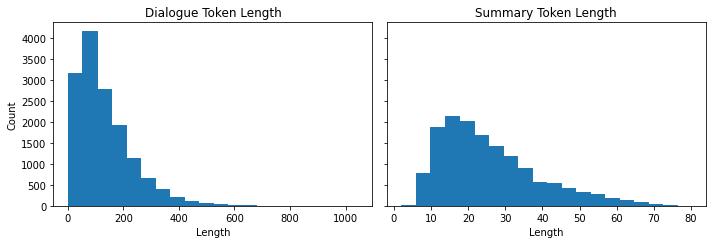

In [31]:
# length distribution of the input and outputs
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [32]:
# tokenize the dataset
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024, truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128, truncation=True)
    
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

#### create the data collator
In most cases we can use the the default collator which collects all the tensors from the batch and simply stacks them.
For the summarization task we need to implement two extra steps: trim the batches to reduce unnecessary padding and prepare the decoder inputs and labels

Ideally, the input length for each batch would be the maximum sequence length in that batch, not the global one. 
We can do this in the collator by dropping all columns in the batch that only contain padding tokens.

In [33]:
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, 
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [34]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [35]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

In [38]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [39]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"], 
                  eval_dataset=dataset_samsum_pt["validation"])

Cloning https://huggingface.co/RayY/pegasus-samsum into local empty directory.


In [40]:
trainer.train

<bound method Trainer.train of <transformers.trainer.Trainer object at 0x7fd73a6a5c90>>

In [41]:
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

100%|██████████| 410/410 [13:21<00:00,  1.96s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296239,0.087567,0.229115,0.229698


In [42]:
trainer.push_to_hub("Training complete!")

Saving model checkpoint to pegasus-samsum
Configuration saved in pegasus-samsum/config.json
Model weights saved in pegasus-samsum/pytorch_model.bin
tokenizer config file saved in pegasus-samsum/tokenizer_config.json
Special tokens file saved in pegasus-samsum/special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 3.33k/2.13G [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.11k/3.11k [00:00<?, ?B/s]

Upload file spiece.model:   0%|          | 3.34k/1.82M [00:00<?, ?B/s]

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/RayY/pegasus-samsum
   f235443..93d0978  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'dataset': {'name': 'samsum', 'type': 'samsum', 'args': 'samsum'}}
remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/RayY/pegasus-samsum
   93d0978..83f9c43  main -> main



'https://huggingface.co/RayY/pegasus-samsum/commit/93d0978b28b1f2d982bddf9323a50f745879a012'